# Intro

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

ModuleNotFoundError: No module named 'fastai'

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from PIL import Image
import os
import cv2
import numpy as np

In [4]:
PATH_TO_DATA="path/to/data/superfolder/"
PATH = PATH_TO_DATA+"colorectal_cancer/"

In [5]:
def get_data(sz):
    tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [6]:
sz=224
arch=resnet34
data = get_data(sz)
data.classes

['adipose',
 'complex',
 'debris',
 'empty',
 'lympho',
 'mucosa',
 'stroma',
 'tumor']

# Choosing a learning rate

In [7]:
learn = ConvLearner.pretrained(arch, data)

In [8]:
lrf=learn.lr_find()

 96%|█████████▌| 44/46 [00:06<00:00,  8.95it/s, loss=2.76]


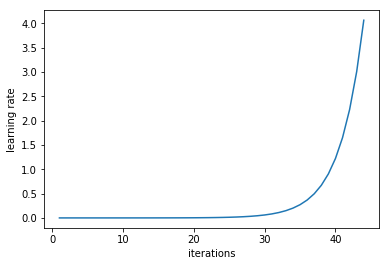

In [9]:
learn.sched.plot_lr()

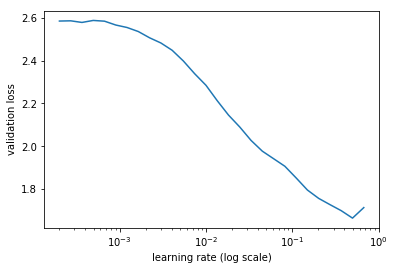

In [10]:
learn.sched.plot()

## Model training

In [11]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [12]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data)

In [13]:
lr=0.08
learn.fit(lr, 5)

epoch      trn_loss   val_loss   accuracy                  
    0      0.733844   0.598476   0.845761  
    1      0.567202   0.423138   0.869254                  
    2      0.487453   0.382565   0.877426                  
    3      0.412465   0.302537   0.906027                  
    4      0.376598   0.300826   0.905005                  



[array([0.30083]), 0.9050051069478823]

In [14]:
learn.precompute=False

In [15]:
learn.fit(lr, 2, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.27526    0.286111   0.910112  
    1      0.248258   0.292121   0.910112                  
    2      0.269151   0.291014   0.901941                  
    3      0.253227   0.284987   0.914198                  



[array([0.28499]), 0.9141981610847567]

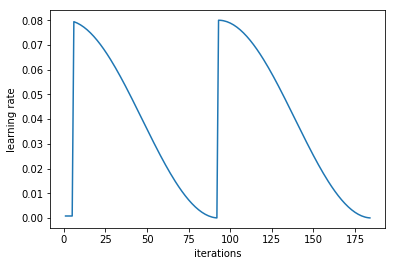

In [16]:
learn.sched.plot_lr()

In [17]:
learn.save('224_lastlayer')

In [18]:
learn.load('224_lastlayer')

## Improving Accuracy with Diff LR

In [19]:
learn.unfreeze()

In [20]:
lrs=np.array([5e-4,5e-3,5e-2])

In [21]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.480474   0.258371   0.91522   
    1      0.329731   0.218275   0.933606                  
    2      0.219086   0.189764   0.941777                  



[array([0.18976]), 0.941777324225978]

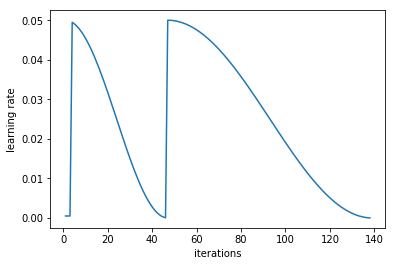

In [22]:
learn.sched.plot_lr()

In [23]:
learn.save('224_all')

In [24]:
learn.load('224_all')

In [25]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [26]:
accuracy_np(probs, y)

0.940755873340143

# Analyzing results

## Confusion matrix

In [27]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[121   0   1   3   0   0   0   0]
 [  0 113   0   0   3   0   8   0]
 [  0   2 145   0   0   0   4   0]
 [  0   0   0 103   0   0   0   0]
 [  0  16   0   0  93   0   0   0]
 [  0   2   0   0   2 127   0   0]
 [  0   7   2   0   1   0 106   0]
 [  0   2   0   0   0   4   1 113]]


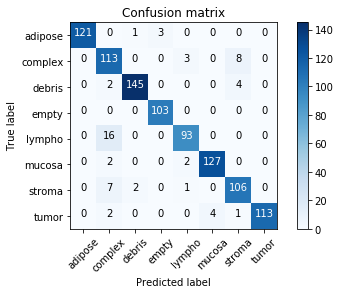

In [29]:
plot_confusion_matrix(cm, data.classes)

# WSI application

## Data treatment

In [30]:
# Set working directory to large 10 images
workingdir = 'point/to/Kather_texture_2016_larger_images_10/'

## Image fragmentation

In [31]:
def image_slice(image_path, outdir, sliceHeight, sliceWidth):
    img = Image.open(image_path) # Load image
    imageWidth, imageHeight = img.size # Get image dimensions
    left = 0 # Set the left-most edge
    upper = 0 # Set the top-most edge
    while (left < imageWidth):
        while (upper < imageHeight):
            # If the bottom and right of the cropping box overruns the image.
            if (upper + sliceHeight > imageHeight and \
                left + sliceWidth > imageWidth):
                bbox = (left, upper, imageWidth, imageHeight)
            # If the right of the cropping box overruns the image
            elif (left + sliceWidth > imageWidth):
                bbox = (left, upper, imageWidth, upper + sliceHeight)
            # If the bottom of the cropping box overruns the image
            elif (upper + sliceHeight > imageHeight):
                bbox = (left, upper, left + sliceWidth, imageHeight)
            # If the entire cropping box is inside the image,
            # proceed normally.
            else:
                bbox = (left, upper, left + sliceWidth, upper + sliceHeight)
            working_slice = img.crop(bbox) # Crop image based on created bounds
            # Save your new cropped image.
            working_slice.save(os.path.join(outdir, str(upper) + '_' + str(left) + '.jpg'))
            upper += sliceHeight # Increment the horizontal position
        left += sliceWidth # Increment the vertical position
        upper = 0

In [32]:
#name of the large images
files_to_move=!ls {workingdir} | grep CRC

In [33]:
#Move large kather slides to their directories from a folder with those images only
for i in range(1,11):
    !mkdir {workingdir+str(i)}
    !mv {workingdir+files_to_move[i-1]} {workingdir+str(i)+'/'+files_to_move[i-1]}

mkdir: cannot create directory ‘/home/deak/fastai/data/Kather_texture_2016_larger_images_10/1’: File exists
mkdir: cannot create directory ‘/home/deak/fastai/data/Kather_texture_2016_larger_images_10/2’: File exists
mkdir: cannot create directory ‘/home/deak/fastai/data/Kather_texture_2016_larger_images_10/3’: File exists
mkdir: cannot create directory ‘/home/deak/fastai/data/Kather_texture_2016_larger_images_10/4’: File exists
mkdir: cannot create directory ‘/home/deak/fastai/data/Kather_texture_2016_larger_images_10/5’: File exists
mkdir: cannot create directory ‘/home/deak/fastai/data/Kather_texture_2016_larger_images_10/6’: File exists
mkdir: cannot create directory ‘/home/deak/fastai/data/Kather_texture_2016_larger_images_10/7’: File exists
mkdir: cannot create directory ‘/home/deak/fastai/data/Kather_texture_2016_larger_images_10/8’: File exists
mkdir: cannot create directory ‘/home/deak/fastai/data/Kather_texture_2016_larger_images_10/9’: File exists
mkdir: cannot create directo

In [34]:
# Run to slice the large images in the folders they are still
if __name__ == '__main__':
    # Iterate through all the files in a set of directories.
    for subdir, dirs, files in os.walk(workingdir):
        for file in files:
            image_slice(subdir + '/' + file, subdir, 150, 150)

In [35]:
#extract large images from slided images folder
for i in range(1,11):
    !mv {workingdir+str(i)+'/'+files_to_move[i-1]} {workingdir+files_to_move[i-1]} 

# Individual prediction

In [36]:
trn_tfms, val_tfms = tfms

In [37]:
for i in range(1,11):
        if i==1: files1 = os.listdir(f'{workingdir}'+f'{i}')
        if i==2: files2 = os.listdir(f'{workingdir}'+f'{i}')
        if i==3: files3 = os.listdir(f'{workingdir}'+f'{i}')
        if i==4: files4 = os.listdir(f'{workingdir}'+f'{i}')
        if i==5: files5 = os.listdir(f'{workingdir}'+f'{i}')
        if i==6: files6 = os.listdir(f'{workingdir}'+f'{i}')
        if i==7: files7 = os.listdir(f'{workingdir}'+f'{i}')
        if i==8: files8 = os.listdir(f'{workingdir}'+f'{i}')
        if i==9: files9 = os.listdir(f'{workingdir}'+f'{i}')
        if i==10: files10 = os.listdir(f'{workingdir}'+f'{i}')

In [40]:
def pintar(width, height):
    negre = (0,0,0)
    gris = (120,120,120)
    blanc = (1000,1000,1000)
    lila = (150,20,147)
    blau = (23,140,190)
    groc = (240,220,20)
    verd = (0,210,10)
    tronja = (240,120,30)
    for x in range(width):
        for y in range(height):     
            if prediccions[a]== 'empty': pixels[x, y] = negre
            if prediccions[a]== 'adipose': pixels[x, y] = gris
            if prediccions[a]== 'mucosa': pixels[x, y] = blanc
            if prediccions[a]== 'debris': pixels[x, y] = lila
            if prediccions[a]== 'complex': pixels[x, y] = groc
            if prediccions[a]== 'stroma': pixels[x, y] = verd
            if prediccions[a]== 'tumor': pixels[x, y] = tronja
            if prediccions[a]== 'lympho': pixels[x, y] = blau

In [41]:
for i in range(1,11):
    prediccions = list()
    PATH_LARGE_SUBDIR=f'{workingdir}'+f'{i}'+"/"
    if i==1:
        for a in range(len(files1)):
            im = val_tfms(open_image(PATH_LARGE_SUBDIR + files1[a]))
            preds1 = learn.predict_array(im[None])
            prediccions.append(learn.data.classes[np.argmax(preds1)])
            imagen = Image.open(PATH_LARGE_SUBDIR+files1[a])
            pixels = imagen.load()
            width, height = imagen.size
            pintar(width,height)
            imagen.save(PATH_LARGE_SUBDIR + files1[a], 'JPEG')
    if i==2:
        for a in range(len(files2)):
            im = val_tfms(open_image(PATH_LARGE_SUBDIR + files2[a])) 
            preds2 = learn.predict_array(im[None])
            prediccions.append(learn.data.classes[np.argmax(preds2)])
            imagen = Image.open(PATH_LARGE_SUBDIR+files2[a])
            pixels = imagen.load()
            width, height = imagen.size
            pintar(width,height)
            imagen.save(PATH_LARGE_SUBDIR + files2[a], 'JPEG')
    if i==3:
        for a in range(len(files3)):
            im = val_tfms(open_image(PATH_LARGE_SUBDIR + files3[a])) 
            preds3 = learn.predict_array(im[None])
            prediccions.append(learn.data.classes[np.argmax(preds3)])
            imagen = Image.open(PATH_LARGE_SUBDIR+files3[a])
            pixels = imagen.load()
            width, height = imagen.size
            pintar(width,height)
            imagen.save(PATH_LARGE_SUBDIR + files3[a], 'JPEG')
    if i==4:
        for a in range(len(files4)):
            im = val_tfms(open_image(PATH_LARGE_SUBDIR + files4[a])) 
            preds4 = learn.predict_array(im[None])
            prediccions.append(learn.data.classes[np.argmax(preds4)])
            imagen = Image.open(PATH_LARGE_SUBDIR+files4[a])
            pixels = imagen.load()
            width, height = imagen.size
            pintar(width,height)
            imagen.save(PATH_LARGE_SUBDIR + files4[a], 'JPEG')
    if i==5:
        for a in range(len(files5)):
            im = val_tfms(open_image(PATH_LARGE_SUBDIR + files5[a])) 
            preds5 = learn.predict_array(im[None])
            prediccions.append(learn.data.classes[np.argmax(preds5)])
            imagen = Image.open(PATH_LARGE_SUBDIR+files5[a])
            pixels = imagen.load()
            width, height = imagen.size
            pintar(width,height)
            imagen.save(PATH_LARGE_SUBDIR + files5[a], 'JPEG')
    if i==6:
        for a in range(len(files6)):
            im = val_tfms(open_image(PATH_LARGE_SUBDIR + files6[a])) 
            preds6 = learn.predict_array(im[None])
            prediccions.append(learn.data.classes[np.argmax(preds6)])
            imagen = Image.open(PATH_LARGE_SUBDIR+files6[a])
            pixels = imagen.load()
            width, height = imagen.size
            pintar(width,height)
            imagen.save(PATH_LARGE_SUBDIR + files6[a], 'JPEG')
    if i==7:
        for a in range(len(files7)):
            im = val_tfms(open_image(PATH_LARGE_SUBDIR + files7[a])) 
            preds7 = learn.predict_array(im[None])
            prediccions.append(learn.data.classes[np.argmax(preds7)])
            imagen = Image.open(PATH_LARGE_SUBDIR+files7[a])
            pixels = imagen.load()
            width, height = imagen.size
            pintar(width,height)
            imagen.save(PATH_LARGE_SUBDIR + files7[a], 'JPEG')
    if i==8:
        for a in range(len(files8)):
            im = val_tfms(open_image(PATH_LARGE_SUBDIR + files8[a])) 
            preds8 = learn.predict_array(im[None])
            prediccions.append(learn.data.classes[np.argmax(preds8)])
            imagen = Image.open(PATH_LARGE_SUBDIR+files8[a])
            pixels = imagen.load()
            width, height = imagen.size
            pintar(width,height)
            imagen.save(PATH_LARGE_SUBDIR + files8[a], 'JPEG')
    if i==9:
        for a in range(len(files9)):
            im = val_tfms(open_image(PATH_LARGE_SUBDIR + files9[a])) 
            preds9 = learn.predict_array(im[None])
            prediccions.append(learn.data.classes[np.argmax(preds9)])
            imagen = Image.open(PATH_LARGE_SUBDIR+files9[a])
            pixels = imagen.load()
            width, height = imagen.size
            pintar(width,height)
            imagen.save(PATH_LARGE_SUBDIR + files9[a], 'JPEG')
    if i==10:
        for a in range(len(files10)):
            im = val_tfms(open_image(PATH_LARGE_SUBDIR + files9[a])) 
            preds10 = learn.predict_array(im[None])
            prediccions.append(learn.data.classes[np.argmax(preds10)])
            imagen = Image.open(PATH_LARGE_SUBDIR+files10[a])
            pixels = imagen.load()
            width, height = imagen.size
            pintar(width,height)
            imagen.save(PATH_LARGE_SUBDIR + files10[a], 'JPEG')
    

## Rebuild WSI with classifications

In [42]:
#ensamble large images with predicted colors
for g in range(len(files_to_move)):
    imagen = Image.open(workingdir+files_to_move[g])
    slices = !ls {workingdir+str(g+1)+'/'} #names of the sliced squares
    for i in range(len(slices)): #for each slice in the folder
        j=0
        k=1 #counters to number the length of the elements
        vertical= str()
        horitzontal= str()
        while slices[i][j]!="_": #following the name architecture to obtain the position of the image
            vertical= vertical+slices[i][j]
            j=j+1
        while slices[i][len(vertical)+k]!=".":
            horitzontal= horitzontal+slices[i][len(vertical)+k]
            k=k+1
        sliced = Image.open(workingdir+str(g+1)+'/'+vertical+"_"+horitzontal+'.jpg')
        imagen.paste(sliced,(int(horitzontal),int(vertical)))
    imagen.save(f'{PATH_TO_DATA}'+f'{files_to_move[g]}')

Resulting images have been classified by the algorithm without the supervision of any kind of doctor.